<a href="https://colab.research.google.com/github/seunga2590/SK_Hynix_Project/blob/main/hynix_preprocessing_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name='01'></a>
## 1. 분석환경 구축 

### 라이브러리 import

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 읽기를 위한 라이브러리
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
from datetime import datetime, date, timedelta
from sklearn.preprocessing import StandardScaler, LabelEncoder

rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

# 탐색적 데이터 분석을 위한 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, probplot, boxcox
from itertools import product

# 모델링을 위한 라이브러리
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression, VarianceThreshold, RFECV
from catboost import CatBoostRegressor
from lightgbm import LGBMClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

# AUTO ML을 활용하기 위한 라이브러리
from pycaret.regression import *

# 하이퍼파라미터 튜닝을 위한 라이브러리
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

## 2. 데이터 읽기

In [ ]:
path = "./dataset/"

# 학습용 데이터 
train_sensor = pd.read_csv(f'{path}train_sensor.csv')
train_quality = pd.read_csv(f'{path}train_quality.csv')

# 평가용 데이터 
predict_sensor = pd.read_csv(f'{path}predict_sensor.csv')

### 2.1 데이터 통합 

학습 데이터의 특징과 타깃 변수가 다른 파일에 존재하므로, 이를 통합

key_val 을 기준으로 train_sensor (X인자)와 train_quality (y인자)의 데이터프레임을 통합

key_val 별 665개의 센서값 컬럼을 생성하기 위해 pandas의 pivot_table 함수를 사용

pivot_table 의 주요 인자는 **index, agg_func, columns**

1. **index** : key_val 을 기준으로 그룹핑을 하고자 하므로, index 에 key_val 과 그의 상위 그룹인 module_name 을 입력
2. **agg_func** : values 에 mean_val 을 입력하고, 해당 값에 대한 산식을 sum으로 설정
3. **columns** : step_param 을 columns 인자로 주어, key_val 별 665개의 스텝 단위의 센서 특징을 생성

In [ ]:
def make_dataset(X, y=None):
    
    # -----------------------------------
    # train_sensor (X 인자)
    # -----------------------------------
    df_X = X.copy()
    # step_id가 한자리일 경우 앞에 0으로 채움
    df_X['step_id'] = df_X['step_id'].apply(lambda x: str(x).zfill(2))
    # step_id 와 param_alias 를 결합한 임시 컬럼 step_param 을 생성ex. 17_EPD_para4
    df_X['step_param'] = df_X[['step_id', 'param_alias']].apply(lambda x: '_'.join(x), axis=1)
    print('feature 개수 : {}'.format(len(set(df_X['step_param']))))
    df_X_tmp = df_X.pivot_table(index = ['module_name','key_val'], columns = 'step_param', values='mean_val', aggfunc='sum')
    # 데이터 통합을 위해 인덱스를 key_val 로 재설정
    df_X_tmp = df_X_tmp.reset_index(level=[0, 1])
    df_X_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # 시간 데이터 
    # -----------------------------------
    df_X['end_time_tmp'] = df_X.apply(lambda x: x['step_id'] + '_end_time', axis=1)
    df_X['end_time'] = pd.to_datetime(df_X['end_time'])

    # end_time 은 센서 데이터가 서버에 도달한 시간으로 스텝 내 오차가 발생 가능. 동일 스텝 구간내 공정 완료 시간이 다른 경우, max 함수를 사용하여 가장 최근에 
    # 수집된 시간 이용
    df_time_tmp = df_X.pivot_table(index = ['key_val'], columns = 'end_time_tmp', values='end_time', aggfunc=lambda x : max(x.unique()))
    df_time_tmp = df_time_tmp.reset_index()
    df_time_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # train_quality (y 인자)
    # -----------------------------------

    if y is None : # 평가용 데이터 
      
        col_target = []
        col_idx = ['module_name', 'key_val']
        df_complete = pd.concat([df_X_tmp, df_time_tmp], axis=1).reset_index()
        df_complete = df_complete.rename(columns={'index': 'key_val'})  
    
    else : # 학습용 데이터 
        df_y = y.copy()
        df_y.set_index('key_val', inplace=True)
      
        col_target = ['y']
        col_idx = ['module_name', 'key_val', 'end_dt_tm']
      
        # 센서 데이터, 시간데이터, 품질지표에 대하여 인덱스(key_val)기준으로 데이터프레임을 통합
        df_complete = pd.concat([df_X_tmp, df_time_tmp, df_y], axis=1).reset_index()
        df_complete = df_complete.rename(columns={'index': 'key_val'})
        # 컬럼 이름 변경
        df_complete.rename(columns={'msure_val':'y'}, inplace=True)

    # 컬럼 순서 정렬
    col_feats = df_X['step_param'].unique().tolist()
    col_feats.sort()
    col_time = [s for s in df_complete.columns.tolist() if "_end_time" in s]
    col_all = col_idx + col_target + col_feats + col_time
    df_complete = df_complete[col_all]
    
    # 컬럼을 소문자로 변경
    df_complete.columns = df_complete.columns.str.lower()

    return df_complete


In [ ]:
# 학습용 데이터 
train = make_dataset(train_sensor, train_quality)
# 평가용 데이터 
predict = make_dataset(predict_sensor)

feature 개수 : 665
feature 개수 : 665


### 2.2 데이터 설명

In [ ]:
def describe_(df, pred=None): 
    
    obs = df.shape[0]
    types = df.dtypes # 자료형 
    counts = df.apply(lambda x: x.count()) # 값의 갯수 
    uniques = df.apply(lambda x: x.unique()) # 고유값 
    distincts = df.apply(lambda x: x.unique().shape[0]) # 고유값의 갯수 
    nulls = df.apply(lambda x: x.isnull().sum()) # 결측치의 갯수  
    nulls_ratio = (df.isnull().sum()/ obs) * 100 # 결측 비율 
    skewness = df.skew() # 왜도  
    kurtosis = df.kurt() # 첨도  
    
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'nulls_ratio', 'uniques', 'skewness', 'kurtosis']
        values_ = pd.concat([types, counts, distincts, nulls, nulls_ratio, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        values_ = pd.concat([types, counts, distincts, nulls, nulls_ratio, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'nulls_ratio', 'uniques', 'skewness', 'kurtosis', corr_col ]

    values_.columns = cols
    dtypes = values_.types.value_counts()
    print('___________________________\nData types:\n',values_.types.value_counts())
    print('___________________________')
    
    return values_

In [ ]:
details = describe_(train, 'y')
display(details.sort_values(by='corr y', ascending=False))

Data shape: (611, 676)
___________________________
Data types:
 float64           666
datetime64[ns]      7
object              3
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,nulls_ratio,uniques,skewness,kurtosis,corr y
y,float64,611,591,0,0.0,"[1257.8492, 1253.30152, 1265.93544, 1248.5508,...",-0.059197,0.342927,1.000000
20_temp_para24,float64,611,575,0,0.0,"[50.28713, 51.87376, 49.72592, 51.89357, 49.61...",-0.438729,0.090808,0.196888
13_temp_para24,float64,611,189,0,0.0,"[69.5625, 72.6875, 68.3125, 71.125, 66.125, 72...",-0.309862,-0.110704,0.194742
12_temp_para24,float64,611,425,0,0.0,"[68.45, 70.56667, 67.43333, 70.66666, 66.55932...",-0.340203,-0.064225,0.189035
17_temp_para24,float64,611,419,0,0.0,"[69.63333, 72.21667, 69.96667, 71.73333, 69.35...",-0.439029,0.009083,0.183320
...,...,...,...,...,...,...,...,...,...
12_end_time,datetime64[ns],611,611,0,0.0,"[2021-10-18T11:16:38.000000000, 2021-10-04T11:...",NaN,NaN,NaN
13_end_time,datetime64[ns],611,611,0,0.0,"[2021-10-18T11:16:54.000000000, 2021-10-04T11:...",NaN,NaN,NaN
17_end_time,datetime64[ns],611,611,0,0.0,"[2021-10-18T11:24:51.000000000, 2021-10-04T11:...",NaN,NaN,NaN
18_end_time,datetime64[ns],611,611,0,0.0,"[2021-10-18T11:25:07.000000000, 2021-10-04T11:...",NaN,NaN,NaN


## 3. 탐색적 데이터 분석 

탐색적 데이터 분석을 통해 **데이터를 이해**하고, 모델에 유용한 **특징을 생성** 

- 데이터에 대한 이해를 높이기 위해 타깃 변수의 분포 (3.1절), 각 센서 변수와 타깃 변수와의 상관 관계 (3.2절)를 파악

- 새로운 특징을 도출하기 위해 범주형 변수에 따른 타깃 변수의 변화 (3.3절) , 전체 공정 소요시간에 따른 타깃 변수의 변화 (3.4절) , 센서 변수의 집약된 통계량 (3.5절)

In [ ]:
# EDA를 위한 학습 데이터를 복사
df_eda = train.copy()

# 센서 컬럼과 날짜 컬럼을 정의
col_sensor = df_eda.iloc[:, 4:-7].columns.tolist() 
col_time = df_eda.filter(regex='end').columns.tolist() 

assert len(col_sensor) == 665
assert len(col_time) == 8 

# 3.4절 공정 소요시간 분석에 필요한 변수를 정의
lst_steps = ['04','06','12','13','17','18', '20']
lst_stepsgap = ['0406','0412','0413','0417','0418','0612','0613','0617','0618','0620',
                '1213','1217','1218','1220','1317','1318','1320','1718','1720','1820']

lst_sensors = []
for step in lst_steps:
    _ = [col for col in col_sensor if col[:2] == step]
    lst_sensors.append(_)

sensors_nm = list(map(lambda x: x[3:], lst_sensors[0]))

# 시간과 관련한 분석을 진행하기 위하여 날짜형으로 변환
df_eda[col_time] = df_eda[col_time].apply(pd.to_datetime)

### 3.1 타깃 변수 분포 확인하기 

학습 데이터를 이용한 타깃 변수의 분포 확인

Seaborn 의 **distplot** 과 **probplot** 을 사용하여 타깃 변수의 분포 범위와 해당 값이 특정 구간에 치우쳐 있는지를 확인

In [ ]:
def QQ_plot(data, measure):
    
    # 그래프의 크기 지정
    fig = plt.figure(figsize=(10,4))
    
    # 1행 2열의 첫번째 히스토그램 그래프
    fig1 = fig.add_subplot(121)
    (mu, sigma) = norm.fit(data)
    # distplot 으로 타깃 변수의 분포를 확인, kde = True를 입력하면 커널밀도추정 결과를 함께 표기
    sns.distplot(data, kde=True, fit=norm)
    fig1.legend(['KDE', f'N({round(mu, 2)},{round(sigma**2, 2)})'], loc='upper right')
    fig1.set_title(f'{measure} Distribution', loc='center')
    fig1.set_xlabel(f'{measure}')

    # 1행 2열의 두번째 QQ Plot 그래프
    fig2 = fig.add_subplot(122)
    # 정규분포와 타깃변수의 분포를 비교
    res = probplot(data, plot=fig2)
    fig2.set_title(f'{measure} Probability Plot', loc='center')

    plt.tight_layout()
    plt.show()


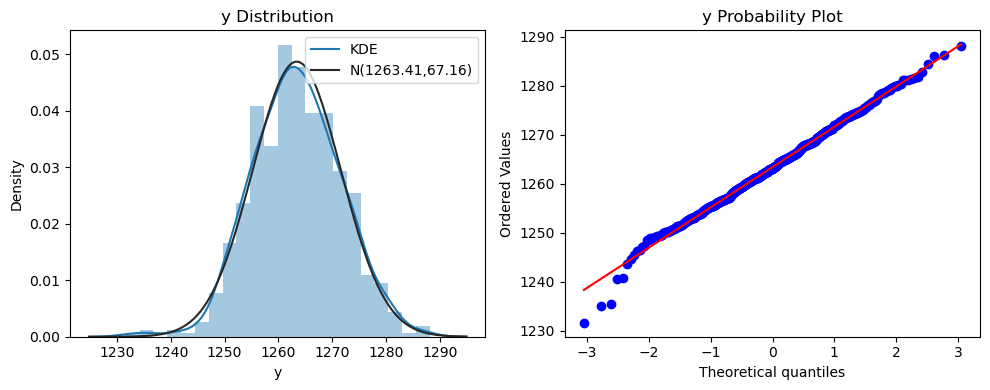

In [ ]:
QQ_plot(df_eda['y'], 'y')

> 타깃은 평균 1263.41, 분산 67.16 인 정규분포를 따름

### 3.2 센서 변수와 타깃 변수의 상관관계 파악
총 665개의 센서 변수와 타깃 변수 y 간의 관련성이 있는지 확인

95개의 센서 변수는 총 7개의 공정 스텝 (4, 6, 12, 13, 17, 18, 20) 단위로 수집

In [ ]:
def regplots(cols, data):
    
    # 각 센서별 7개의 스텝을 가지므로 행이 2개이고, 열이 4개인 서브 플롯을 생성
    fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(15,8))
    
    # 서브 플롯 간의 세로 간격(hspace) 가로 간격(wspace)을 설정
    fig.subplots_adjust(hspace=.4, wspace=.1)
    
    for i, ax in zip(range(len(cols)), axes.flat):

        sns.regplot(x=cols[i], y='y', data=data, ax=ax)
        ax.set_title(f'{cols[i].upper()}')
        ax.set_xlabel('')
        ax.set_ylabel('')
    
    axes.flat[-1].set_visible(False)
    plt.tight_layout()
    plt.show()

*****['efem_para2']


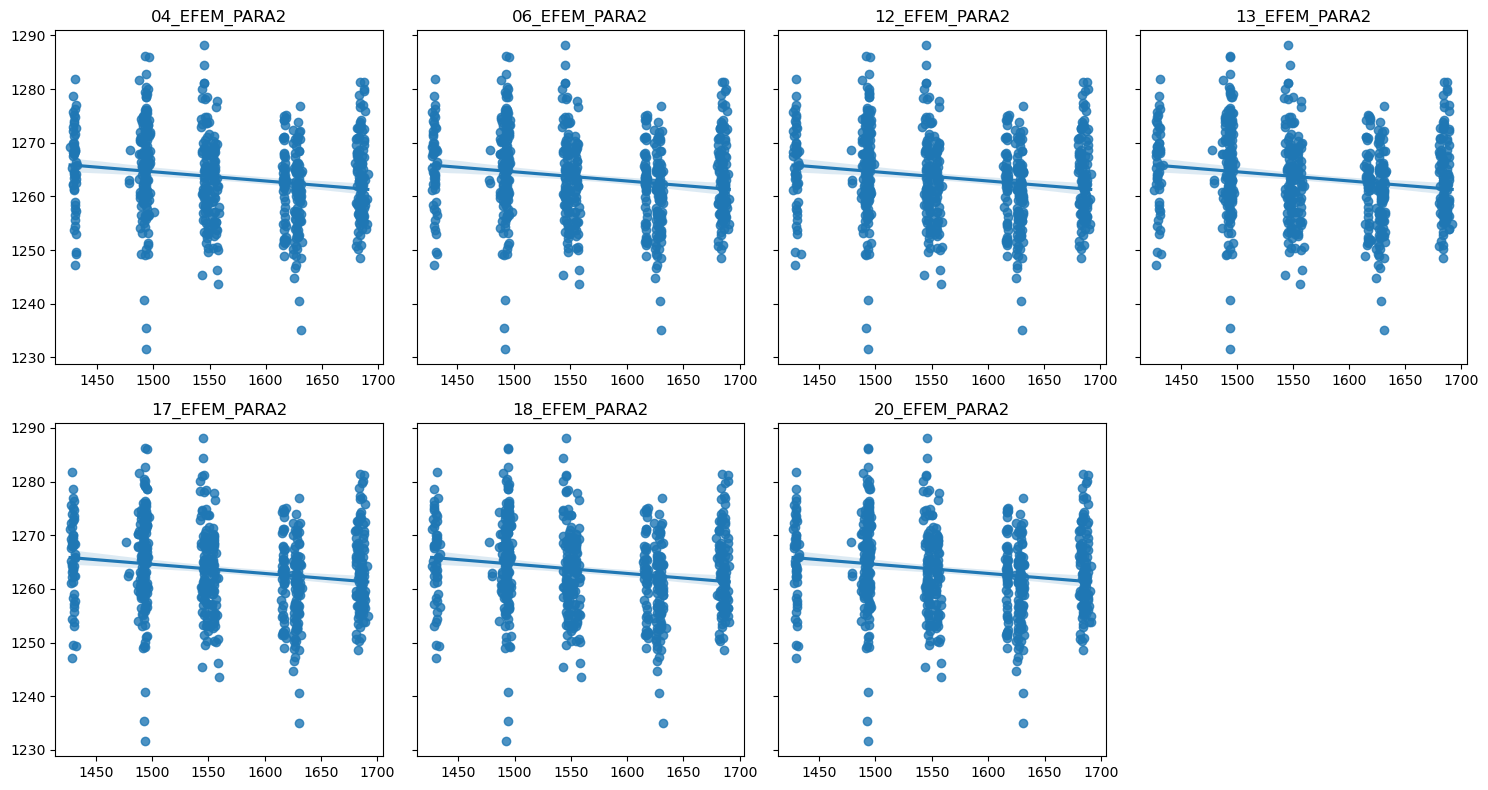

In [ ]:
for ix, sensor_nm in enumerate(sensors_nm):
    print(f'*****{[sensor_nm]}')

    # tmp_lst 는 {스텝}_{센서명} 형식으로 센서의 총 7개의 스텝 컬럼 리스트를 생성
    # ex. 04_efem_para2, 06_efem_para2, ..., 20_efem_para2
    tmp_lst = list(map(lambda x: f'{x}_{sensor_nm}', lst_steps))
    regplots(tmp_lst, df_eda)
    
    if ix == 0:
        break

### 3.3 범주형 변수에 따른 타깃 변수의 변화

총 모듈(module_name)의 고유값의 갯수는 47개 모듈 이름은 _ 를 기준으로 EQ와 PM 식별자로 조합

In [ ]:
idx = 'module_name'
# 모듈의 고유값, 고유값의 갯수
module_unq = df_eda[idx].unique()
module_nunq = df_eda[idx].nunique()

print(f'***')
print(f'No. of Module : {module_nunq}')
print(f'{module_unq}')

***
No. of Module : 47
['EQ10_PM1' 'EQ10_PM2' 'EQ10_PM5' 'EQ10_PM6' 'EQ11_PM1' 'EQ11_PM2'
 'EQ11_PM5' 'EQ11_PM6' 'EQ12_PM1' 'EQ12_PM2' 'EQ12_PM5' 'EQ12_PM6'
 'EQ1_PM1' 'EQ1_PM2' 'EQ1_PM5' 'EQ1_PM6' 'EQ2_PM1' 'EQ2_PM2' 'EQ2_PM5'
 'EQ2_PM6' 'EQ3_PM1' 'EQ3_PM2' 'EQ3_PM5' 'EQ3_PM6' 'EQ4_PM1' 'EQ4_PM2'
 'EQ4_PM5' 'EQ4_PM6' 'EQ5_PM1' 'EQ5_PM2' 'EQ5_PM5' 'EQ5_PM6' 'EQ6_PM1'
 'EQ6_PM2' 'EQ6_PM5' 'EQ6_PM6' 'EQ7_PM1' 'EQ7_PM2' 'EQ7_PM5' 'EQ7_PM6'
 'EQ8_PM1' 'EQ8_PM2' 'EQ8_PM5' 'EQ8_PM6' 'EQ9_PM1' 'EQ9_PM2' 'EQ9_PM5']


<AxesSubplot:xlabel='module_name_eq', ylabel='y'>

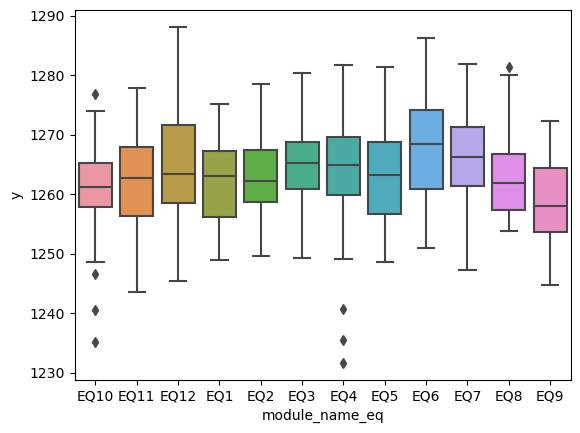

In [ ]:
# 모듈 이름의 상위 집계단위를 나타내는 module_name_eq 범주형 변수 생성
def gen_cate_feats(df):
    df['module_name_eq'] = df['module_name'].apply(lambda x : x.split('_')[0])
    return df 
   
df_eda = gen_cate_feats(df_eda)
sns.boxplot(x='module_name_eq', y='y', data=df_eda)

### 3.4 전체 공정 소요시간에 따른 타깃 변수의 변화 

전체 및 개별 공정 소요시간 변수를 생성하는 함수를 작성

전체 공정 소요시간은 마지막 공정 완료시간 ***20_end_time*** 과 첫번째 공정 완료시간 **04_end_time** 의 차이(초)를 계산한 값

In [ ]:
# 전체 및 개별 공정 소요시간 변수를 생성하는 함수
def gen_duration_feats(df, lst_stepsgap):
    
    # 전체 공정 소요시간(초) 변수를 생성
    df['gen_tmdiff'] = (df['20_end_time'] - df['04_end_time']).dt.total_seconds()

    # 개별 스텝간 공정 소요시간(초) 변수를 생성
    # ex. gen_tmdiff_0406 : 04 스텝 공정 완료 시간과 06 스텝 공정 완료 시간의 차이 
    for stepgap in lst_stepsgap:
        df[f'gen_tmdiff_{stepgap}'] = (df[f'{stepgap[2:]}_end_time'] - df[f'{stepgap[:2]}_end_time']).dt.total_seconds()

    return df

df_eda = gen_duration_feats(df_eda, lst_stepsgap)

> 전체 공정 소요시간은 최소 30.6분 ~ 최대 31.9분 

> 개별 스텝간 공정 소요시간도 확인하였을 때, 6번째 스텝에서 12번째 스텝 간 소요시간이 가장 긺

In [ ]:
# 전체 공정 소요시간 및 개별 공정 소요시간 컬럼을 리스트 형태로 추출
col_tmdiff = df_eda.filter(regex='gen_tmdiff($|_\d)').columns.tolist()

# 공정 소요시간의 통계값(최소, 최대, 평균)을 추출하는 함수
def tmdiff_stats(x):
    return [round(x.min()/60,1), round(x.max()/60,1), round(x.mean()/60,1)]

df_tmp = df_eda[col_tmdiff].apply(tmdiff_stats).T
df_tmp.columns = ['MIN', 'MAX', 'MEAN']
df_tmp

,MIN,MAX,MEAN
gen_tmdiff,30.6,31.9,31.5
gen_tmdiff_0406,2.0,2.5,2.3
gen_tmdiff_0412,15.3,16.6,16.2
gen_tmdiff_0413,15.5,16.9,16.5
gen_tmdiff_0417,23.4,24.8,24.4
gen_tmdiff_0418,23.7,25.1,24.7
gen_tmdiff_0612,13.3,14.2,13.9
gen_tmdiff_0613,13.5,14.4,14.2
gen_tmdiff_0617,21.5,22.4,22.1
gen_tmdiff_0618,21.7,22.7,22.4


> 전체 공정 소요시간은 30분대 공정이 완료된 장비와 31분대에 공정이 완료된 장비로 뚜렷하게 구분

> 대부분의 장비는 31분대에 완료되었으며, 일찍 공정을 마친 장비는 주로 EQ7, EQ8 모듈


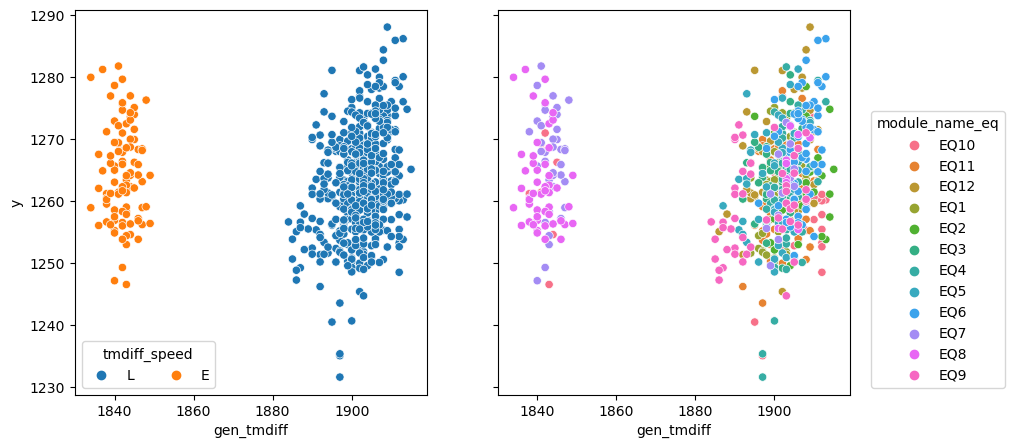

In [ ]:
# 시각화를 위하여 1870초를 기준으로 일찍 마친 장비와 늦께 마친 장비를 구분
df_eda.loc[df_eda['gen_tmdiff'] < 1870, 'tmdiff_speed'] = 'E' # Early 
df_eda.loc[df_eda['gen_tmdiff'] > 1870, 'tmdiff_speed'] = 'L' # Late

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,5))
sns.scatterplot(x='gen_tmdiff', y='y', hue='tmdiff_speed', data = df_eda, ax=axes[0])
sns.scatterplot(x='gen_tmdiff', y='y', hue='module_name_eq', data = df_eda, ax=axes[1])
axes[0].legend(loc='lower left', ncol=2, title='tmdiff_speed')
axes[1].legend(loc='lower left', ncol=1, title='module_name_eq', bbox_to_anchor=(1.04, 0))

### 3.5 센서의 집약된 통계량에 따른 타깃 변수의 변화

센서 측정치에 대해 총 7개의 스텝을 집약한 표준편차를 확인. 전 구간에서 센서 측정치의 흩어진 정도를 확인

In [ ]:
# 센서의 집약된 표준편차 변수를 생성하는 함수
def gen_stats_feats(df, sensors_nm, lst_steps):
    
    for sensor_nm in sensors_nm:

        # 센서별 총 7개의 스텝 컬럼 리스트를 생성
        # ex. 04_efem_para2, 06_efem_para2, ..., 20_efem_para2
        tmp_lst = list(map(lambda x: f'{x}_{sensor_nm}', lst_steps))

        # 전 스텝을 집약하여 센서의 표준편차 변수를 생성
        df[f'gen_{sensor_nm}_std'] = df[tmp_lst].std(axis=1)
        
    return df

df_eda = gen_stats_feats(df_eda, sensors_nm, lst_steps)

In [ ]:
# 센서의 집약된 평균 변수를 생성하는 함수
def gen_avg_feats(df, sensors_nm, lst_steps):
    
    for sensor_nm in sensors_nm:

        # 센서별 총 7개의 스텝 컬럼 리스트를 생성
        # ex. 04_efem_para2, 06_efem_para2, ..., 20_efem_para2
        tmp_lst = list(map(lambda x: f'{x}_{sensor_nm}', lst_steps))

        # 전 스텝을 집약하여 센서의 표준편차 변수를 생성
        df[f'gen_{sensor_nm}_mean'] = df[tmp_lst].mean(axis=1)
        
    return df

df_eda = gen_avg_feats(df_eda, sensors_nm, lst_steps)

<AxesSubplot:xlabel='gen_time_para5_std', ylabel='y'>

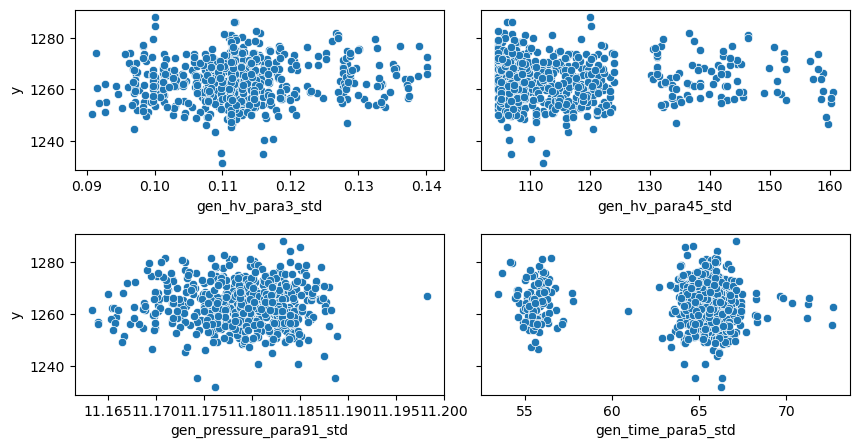

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,5))
fig.subplots_adjust(hspace=.4, wspace=.1)

sns.scatterplot(x='gen_hv_para3_std', y='y', data = df_eda, ax=axes[0,0], legend=False)
sns.scatterplot(x='gen_hv_para45_std', y='y', data = df_eda, ax=axes[0,1], legend=False)
sns.scatterplot(x='gen_pressure_para91_std', y='y',  data = df_eda, ax=axes[1,0], legend=False)
sns.scatterplot(x='gen_time_para5_std', y='y', data = df_eda, ax=axes[1,1], legend=False)


In [ ]:
param_set = set(x.split('_')[0].lower() for x in train_sensor['param_alias'])

In [ ]:
def gen_avg_param(df):

        for i in param_set: # 파라미터가 들어가 있는 컬럼들
                
                param = [x for x in df.columns if i in x and 'para' in x]

                df[f'gen_avg_{i}'] = df[param].mean(axis=1)

        return df

In [ ]:
def gen_avg_param(df):

        for i in param_set: # 파라미터가 들어가 있는 컬럼들
                
                param = [x for x in df.columns if i in x and 'para' in x]

                df[f'gen_avg_{i}'] = df[param].mean(axis=1)

        return df

def gen_std_param(df):

        for i in param_set: # 파라미터가 들어가 있는 컬럼들
                
                param = [x for x in df.columns if i in x and 'para' in x]

                df[f'gen_std_{i}'] = df[param].std(axis=1)

        return df

In [ ]:
def gen_avg_step(df):

    for i in lst_steps:

        param_steps = [x for x in df.columns if i == x.split('_')[0] and 'para' in x]

        df[f'gen_avg_{i}'] = df[param_steps].mean(axis=1)

    return df

In [ ]:
def log_skew(df):
    
    numeric = [k for k in df.columns if df[k].dtype == 'float']
    numeric_lst = pd.DataFrame(abs(df[numeric].skew())).sort_values(by = 0, ascending = False)[:100].index.tolist()
    
    for col in numeric_lst:

        if df[col].skew() < 0:
            df[col] = df[col] **2
        else:
            df[col] = df[col] ** 1/2

    return df

In [ ]:
def cut_data(df, col):

    bins = [1400, 1450, 1520, 1570, 1660, 1750]
    labels = ['a', 'b', 'c', 'd', 'e']

    cuts = pd.cut(df[col], bins, right = False, labels = labels)
    
    return cuts

def cut_epd_data(df, col):
    
    bins_epd4 = [0, 50, 100]
    labels = ['a','b']

    cuts_efem = pd.cut(df[col], bins_epd4, right = False, labels = labels)

    return cuts_efem

In [ ]:
sp_product = list(product(lst_steps, param_set))

step_params = ['_'.join(sp_product[i]) for i in range(len(sp_product))]

In [ ]:
def gen_std_stpa(df):

    for step_param in step_params:

        step_param_cols = [x for x in lst_sensors[0] if step_param in x]

        df[f'gen_{step_param}_std'] =  df[step_param_cols].std(axis=1)

    return df

def gen_avg_stpa(df):

    for step_param in step_params:

        step_param_cols = [x for x in lst_sensors[0] if step_param in x]

        df[f'gen_{step_param}_avg'] =  df[step_param_cols].std(axis=1)

    return df
        
df_eda = gen_std_stpa(df_eda)
df_eda = gen_avg_stpa(df_eda)

In [ ]:
# EDA를 위한 데이터 프레임 제거
del df_eda

## 4. 데이터 전처리

탐색적 데이터 분석을 통해 도출한 추가 변수를 생성(4.1절)

이상치 확인(4.2절), 분산이 적은 특징 제거(4.3절), 수치형 변수의 표준화(4.4절) 그리고 범주형 변수의 원-핫 인코딩(4.5절)

### 4.1 내부 데이터를 통한 변수 생성 



In [ ]:
# 전처리를 위한 학습용 데이터와 평가용 데이터를 복사
df_prep_train = train.copy()
df_prep_predict = predict.copy()

탐색적 데이터 분석(3.3~3.5절)에서 분석한 결과를 활용해 새로운 특징을 생성 


*   모듈 이름의 상위 집계 단위를 나타내는 1개의 범주형 변수 (3.3절)
*   전체 및 개별 공정 소요시간을 나타내는 7개의 변수(3.4절)
*   센서 변수의 집약된 표준편차를 나타내는 95개의 변수 (3.5절)




In [ ]:
# 모듈 이름의 상위 집계 단위를 나타내는 1개의 범주형 변수를 생성(3.3절)
df_prep_train = gen_cate_feats(df_prep_train)
df_prep_predict = gen_cate_feats(df_prep_predict)

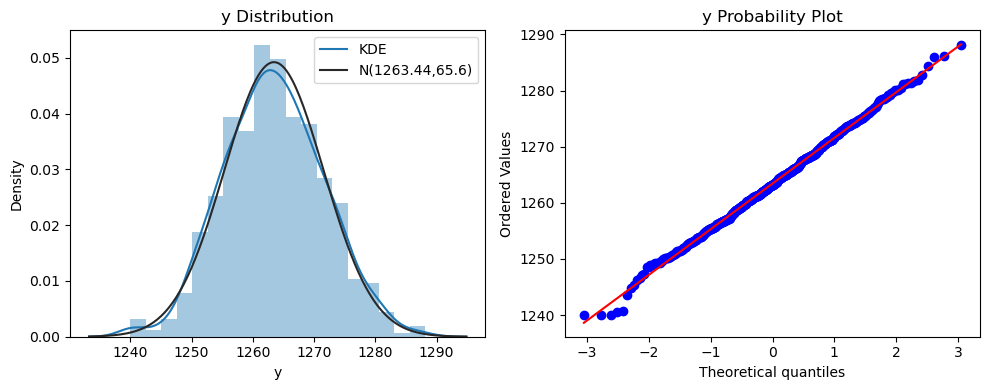

In [ ]:
QQ_plot(df_prep_train['y'].clip(1240, 1500), 'y')

In [ ]:
# y값 1240 이하 값 이상치 clip
df_prep_train['y']  = df_prep_train['y'].clip(1240, 1500)

In [ ]:
# 전체 및 개별 공정 소요시간 7개의 변수를 생성(3.4절)
df_prep_train = gen_duration_feats(df_prep_train, lst_stepsgap)
df_prep_predict = gen_duration_feats(df_prep_predict, lst_stepsgap)

In [ ]:
# 센서 변수의 집약된 95개의 표준편차 변수를 생성(3.5절)
df_prep_train = gen_stats_feats(df_prep_train, sensors_nm, lst_steps)
df_prep_predict = gen_stats_feats(df_prep_predict, sensors_nm, lst_steps)
df_prep_train.filter(regex='_std').head(2)

,gen_efem_para2_std,gen_efem_para25_std,gen_efem_para78_std,gen_epd_para4_std,gen_epd_para40_std,gen_epd_para63_std,gen_epd_para80_std,gen_esc_para84_std,gen_esc_para94_std,gen_fr_para28_std,...,gen_time_para7_std,gen_time_para75_std,gen_time_para77_std,gen_time_para8_std,gen_time_para81_std,gen_time_para83_std,gen_time_para89_std,gen_time_para9_std,gen_time_para90_std,gen_tmp_para31_std
0,1.540604,1.487185,0.045480,377.964435,0.382780,0.0,0.0,0.000000,0.0,2926.724319,...,0.163207,0.163356,0.163356,0.163207,0.163356,0.163207,0.163356,0.163207,0.163356,0.54963
1,1.313742,1.372572,0.045224,377.964435,0.462813,0.0,0.0,0.003024,0.0,2926.724319,...,0.163207,0.165981,0.165981,0.163211,0.165981,0.163207,0.165981,0.163207,0.165981,0.55689


In [ ]:
# 센서 변수의 집약된 95개의 평균 변수를 생성
df_prep_train = gen_avg_feats(df_prep_train, sensors_nm, lst_steps)
df_prep_predict = gen_avg_feats(df_prep_predict, sensors_nm, lst_steps)

In [ ]:
# # 센서 변수의 왜도 첨도 값이 높은 값들 변환
# df_prep_train = log_skew(df_prep_train)
# df_prep_predict = log_skew(df_prep_predict)

In [ ]:
# Scatter Plot에 따른 전처리: 구간 별로 나눠줌

efem_para = [k for k in df_prep_train if ('efem_para2' in k) & ('gen' not in k)]

for col in efem_para:

    df_prep_train[f'cut_{col}'] = cut_data(df_prep_train, col)
    df_prep_predict[f'cut_{col}'] = cut_data(df_prep_predict, col)

df_prep_train['cut_06_epd_para4'] = cut_epd_data(df_prep_train, '06_epd_para4')
df_prep_predict['cut_06_epd_para4'] = cut_epd_data(df_prep_predict, '06_epd_para4')


gas_10_cols = [x for x in df_prep_train.columns if ('gas_para10' in x) & ('gen' not in x)]

for col in gas_10_cols:

    bins = [-0.01, -0.002, 0.002, 0.006, 1]

    labels = ['a','b','c','d']
    
    df_prep_train[f'cut_{col}'] = pd.cut(df_prep_train[col], bins, right = False, labels = labels)
    df_prep_predict[f'cut_{col}'] = pd.cut(df_prep_predict[col], bins, right = False, labels = labels)

gas_19_cols = [x for x in df_prep_train.columns if ('gas_para19' in x) & ('gen' not in x)]

for col in gas_19_cols:

    bins = [-0.01, -0.008, -0.006, -0.004, -0.001, 0.001, 0.003, 1]

    labels = ['a','b','c','d','e','f','g']
    
    df_prep_train[f'cut_{col}'] = pd.cut(df_prep_train[col], bins, right = False, labels = labels)
    df_prep_predict[f'cut_{col}'] = pd.cut(df_prep_predict[col], bins, right = False, labels = labels)

bins = [0.2, 0.255, 0.265, 0.275, 0.3]

labels = ['a','b','c','d']

df_prep_train['cut_20_hv_para3'] = pd.cut(df_prep_train['20_hv_para3'], bins, right = False, labels = labels)
df_prep_predict['cut_20_hv_para3'] = pd.cut(df_prep_predict['20_hv_para3'], bins, right = False, labels = labels)

In [ ]:
# 두 구간으로 나누는 변수 처리
def cut_2(df, col):
    bins = [0, 0.4, 1.0]
    labels = ['A', 'B']

    cuts = pd.cut(df[col], bins, right = False, labels = labels)
    return cuts

#hv 변수 처리
def cut_hv_data(df, col):
    bins = [-2.5, -0.8, 0.5, 2.5]
    labels = ['A', 'B', 'C']

    cuts = pd.cut(df[col], bins, right = False, labels = labels)
    
    return cuts

# he 변수 처리
he_175 = ['04_he_para88', '06_he_para88']
he_30 = ['12_he_para88', '13_he_para88', '17_he_para88', '20_he_para88']

for h1 in he_175:
    df_prep_train[h1]  = df_prep_train[h1].clip(0, 1.75)
    df_prep_predict[h1] = df_prep_predict[h1].clip(0, 1.75)

for h2 in he_30:
    df_prep_train[h2] = df_prep_train[h2].clip(0, 3.0)
    df_prep_predict[h2] = df_prep_predict[h2].clip(0, 3.0)

# fr 변수 처리
cut_01 = ['06_epd_para4', '17_fr_para35', '20_fr_para35']

for cut in cut_01:
    df_prep_train[f'cut_{cut}'] = cut_2(df_prep_train, cut)
    df_prep_predict[f'cut_{cut}'] = cut_2(df_prep_predict, cut)

# time 변수 추가 처리

time_para = ['04', '06', '12', '13', '17', '18', '20']
for time in time_para:
    df_prep_train[f'{time}_time_para16'] = df_prep_train[f'{time}_time_para16'].clip(0, 5000)
    df_prep_predict[f'{time}_time_para16'] = df_prep_predict[f'{time}_time_para16'].clip(0, 5000)

for h1 in he_175:
    df_prep_train[h1]  = df_prep_train[h1].clip(0, 1.75)
    df_prep_predict[h1] = df_prep_predict[h1].clip(0, 1.75)

for h2 in he_30:
    df_prep_train[h2] = df_prep_train[h2].clip(0, 3.0)
    df_prep_predict[h2] = df_prep_predict[h2].clip(0, 3.0)

In [ ]:
# 타겟 변수에 대해 log변환
def log_transform(df,feat_nm):

    df[f'log_{feat_nm}'] = np.log1p(df[feat_nm])

    df.drop(feat_nm, axis=1, inplace=True)

    return df

# df_prep_train = log_transform(df_prep_train, 'y')

In [ ]:
# 870초를 기준으로 일찍 마친 장비와 늦께 마친 장비를 구분
df_prep_train.loc[df_prep_train['gen_tmdiff'] < 1870, 'tmdiff_speed'] = 'E' # Early 
df_prep_train.loc[df_prep_train['gen_tmdiff'] > 1870, 'tmdiff_speed'] = 'L' # Late

df_prep_predict.loc[df_prep_predict['gen_tmdiff'] < 1870, 'tmdiff_speed'] = 'E' # Early 
df_prep_predict.loc[df_prep_predict['gen_tmdiff'] > 1870, 'tmdiff_speed'] = 'L' # Late

### 4.2 이상치 치환하기 

분위점을 임계값으로 삼아 이상치를 치환

학습 데이터의 1%점을 하한, 99%점을 상한으로 잡고 해당 범위를 벗어나는 값을 각각 **하한값과 상한값으로 치환**


In [ ]:
# 이상치 확인을 위한 데이터 복사 
df_outlier = df_prep_train.copy()

In [ ]:
def outlier(x, p01, p99):

    if x < p01 or x > p99:
        return 'Y'
    else:
        return 'N'

# 특정 컬럼의 이상치를 확인
tmp_lst = ['04_fr_para35', '04_gas_para36', '04_fr_para28', '04_temp_para66']


for col in tmp_lst:

    q1 = df_outlier[col].quantile(0.25) 
    q3 = df_outlier[col].quantile(0.75) 

    iqr=q3-q1

    low_lim = q3 + 1.5 * iqr
    high_lim = q1 - 1.5 * iqr

    df_outlier[f'{col}_outlier'] = df_outlier[col].apply(outlier, args=(low_lim, high_lim))

> 상한값과 하한값을 벗어나는 데이터 포인트를 확인

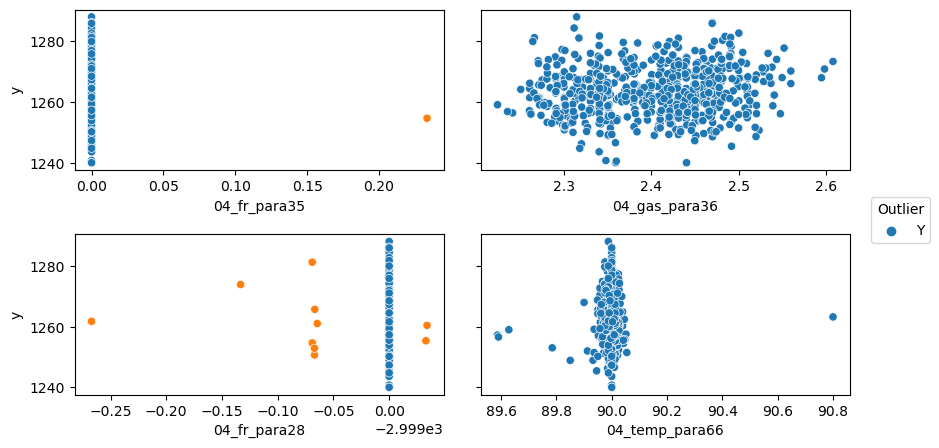

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,5))
fig.subplots_adjust(hspace=.4, wspace=.1)

sns.scatterplot(x='04_fr_para35', y='y', hue='04_fr_para35_outlier', data = df_outlier, ax=axes[0,0], legend=False)
sns.scatterplot(x='04_gas_para36', y='y', hue='04_gas_para36_outlier', data = df_outlier, ax=axes[0,1])
sns.scatterplot(x='04_fr_para28', y='y',  hue='04_fr_para28_outlier', data = df_outlier, ax=axes[1,0], legend=False)
sns.scatterplot(x='04_temp_para66', y='y', hue='04_temp_para66_outlier', data = df_outlier, ax=axes[1,1], legend=False)
axes[0,1].legend(loc='lower left', ncol=1, title='Outlier', bbox_to_anchor=(1.04, -0.5))

In [ ]:
# 기존 센서 변수(665개)와 생성 변수 중 수치형 변수(102개) 컬럼을 정의
col_numerical = col_sensor + df_prep_train.filter(regex='^gen_').columns.tolist()

In [ ]:
def cliping(df,columns):
    
    for col in columns:

        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)

        iqr = q3 - q1

        low_lim = q3 + 1.5 * iqr
        high_lim = q1 - 1.5 * iqr

        df[col] = df[col].clip(low_lim, high_lim)

    return df

df_prep_train = cliping(df_prep_train, col_numerical)
df_prep_predict = cliping(df_prep_predict, col_numerical)

> 이상치 처리후 결과

<AxesSubplot:xlabel='04_temp_para66', ylabel='y'>

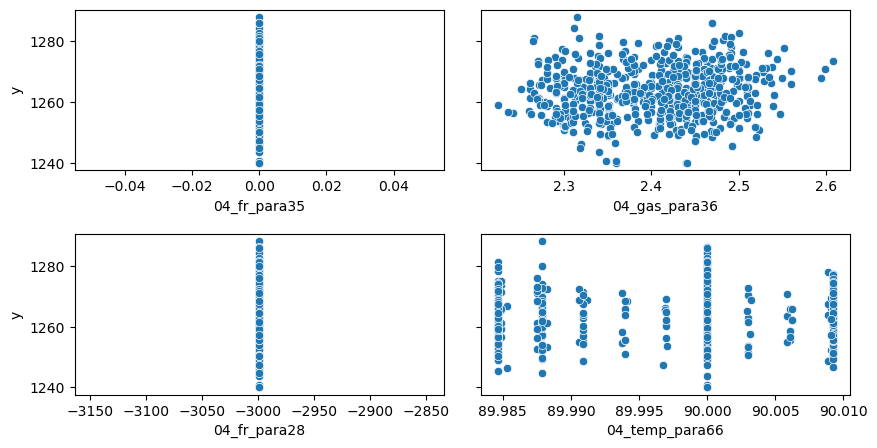

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,5))
fig.subplots_adjust(hspace=.4, wspace=.1)

sns.scatterplot(x='04_fr_para35', y='y', data = df_prep_train, ax=axes[0,0])
sns.scatterplot(x='04_gas_para36', y='y', data = df_prep_train, ax=axes[0,1])
sns.scatterplot(x='04_fr_para28', y='y',  data = df_prep_train, ax=axes[1,0])
sns.scatterplot(x='04_temp_para66', y='y', data = df_prep_train, ax=axes[1,1])

### 4.3 분산이 적은 변수 제거
분산 기준 설정(Variance Thresholding)은 가장 기본적인 특성 선택 방법

분산이 0 인 특징은 정보가 없으므로 해당 특징을 삭제

In [ ]:
# threshold 인자를 변경하여 분산의 기준값을 수동으로 선택
thresholder = VarianceThreshold(threshold=0)
_ = thresholder.fit_transform(df_prep_train[col_numerical])

 # 분산이 0이면 True 이므로 제거할 컬럼을 추출
mask = ~thresholder.get_support()
cols_var_drop = np.asarray(col_numerical)[mask].tolist()
print(f'** {len(cols_var_drop)} Features to Drop by Low Variance')
print(f'{cols_var_drop}')

** 218 Features to Drop by Low Variance
['04_epd_para4', '04_epd_para40', '04_epd_para63', '04_epd_para80', '04_esc_para84', '04_fr_para28', '04_fr_para35', '04_fr_para69', '04_gas_para10', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para70', '04_gas_para71', '04_gas_para74', '04_he_para1', '04_he_para95', '04_power_para14', '04_power_para49', '04_power_para57', '04_power_para68', '04_power_para82', '04_temp_para24', '04_time_para5', '06_epd_para4', '06_epd_para63', '06_epd_para80', '06_esc_para84', '06_fr_para28', '06_fr_para35', '06_fr_para69', '06_gas_para10', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para70', '06_gas_para74', '06_gas_para85', '06_he_para1', '06_he_para95', '06_hv_para3', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para14', '06_power_para68', '06_power_p

<AxesSubplot:xlabel='04_epd_para4', ylabel='y'>

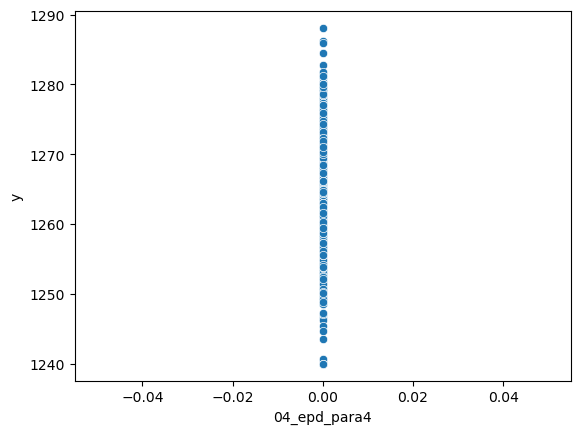

In [ ]:
sns.scatterplot(x=cols_var_drop[0], y='y', data=df_prep_train)

### 4.5 원-핫 인코딩

**module_name_eq** 는 문자열로 나타난 범주형 변수

범주형 변수의 대표적인 변환 기법인 원-핫 인코딩을 사용하여 변환 

In [ ]:
col_cut = df_prep_train.filter(regex = '^cut').columns.tolist()

In [ ]:
def prep_cate_feats(df_tr, df_te, feat_nm):

    df_merge = pd.concat([df_tr, df_te])

    # 컬럼명과 범주형 변수의 레벨명을 이용한 새로운 컬럼명을 자동생성
    # ex. module_name_eq -> module_name_eq_EQ01, module_name_eq_EQ02, etc.
    df_merge = pd.get_dummies(df_merge, columns=[feat_nm])

    df_tr = df_merge.iloc[:df_tr.shape[0], :].reset_index(drop=True)
    df_te = df_merge.iloc[df_tr.shape[0]:, :].reset_index(drop=True)

    return df_tr, df_te

# module_name_eq 의 원-핫 인코딩 변수를 생성
df_prep_train, df_prep_predict = prep_cate_feats(df_prep_train, df_prep_predict, 'module_name_eq')

for col in col_cut:
    df_prep_train, df_prep_predict = prep_cate_feats(df_prep_train, df_prep_predict, col)

In [ ]:
df_prep_train, df_prep_predict = prep_cate_feats(df_prep_train, df_prep_predict, 'tmdiff_speed')

### 다중공선성(VIF)

In [ ]:
df_prep_train.dropna(axis=1, inplace=True)
df_prep_predict.dropna(axis=1, inplace=True)

In [ ]:
## 다중공선성 VIF 확인
# VIF 출력을 위한 데이터 프레임 형성
vif = pd.DataFrame()
idx_numerical = [col for col in df_prep_train.columns if (df_prep_train[col].dtype == 'float') & ('y' not in col)]

# VIF 값과 각 Feature 이름에 대해 설정
vif["VIF Factor"] = [variance_inflation_factor(df_prep_train[idx_numerical].values, i) for i in range(df_prep_train[idx_numerical].shape[1])]
vif["features"] = df_prep_train[idx_numerical].columns

# VIF 값이 높은 순으로 정렬
vif = vif.sort_values(by="VIF Factor", ascending=False)
vif = vif.reset_index().drop(columns='index')
vif

,VIF Factor,features
0,1.452774e+14,04_gas_para33
1,8.918019e+13,06_gas_para33
2,8.660769e+13,12_gas_para33
3,6.721790e+13,12_fr_para61
4,6.479999e+13,gen_fr_para61_mean
...,...,...
871,NaN,gen_epd_para63_mean
872,NaN,gen_epd_para80_mean
873,NaN,gen_gas_para10_mean
874,NaN,gen_gas_para19_mean


In [ ]:
vif_10 = vif[vif['VIF Factor'] > 10]
print(len(vif_10))
print(len([fea for fea in vif_10['features'] if ('mean' not in fea) & ('std' not in fea) & ('avg' not in fea) & ('time' not in fea)&('log_y' not in fea)]))

vif_10_lst = [fea for fea in vif_10['features'] if ('mean' not in fea) & ('std' not in fea) & ('avg' not in fea) & ('time' not in fea)&('log_y' not in fea)]

658
341


In [ ]:
# PCA 처리
pca = PCA(n_components=len(vif_10_lst))

x_train_pca = pca.fit(df_prep_train[vif_10_lst])
x_predict_pca = pca.transform(df_prep_predict[vif_10_lst])

pca_result = pd.DataFrame({'설명 가능한 분산 비율':pca.explained_variance_, '기여율' : pca.explained_variance_ratio_})

In [ ]:
pca_result['누적기여율'] = pca_result['기여율'].cumsum()
# 누적 기여율이 80%가 넘어가는 지점까지 적용

<AxesSubplot:ylabel='설명 가능한 분산 비율'>

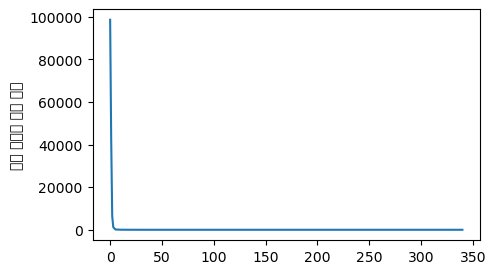

In [ ]:
plt.figure(figsize = (5, 3))
sns.lineplot(x = pca_result.index, y = '설명 가능한 분산 비율', data = pca_result)
# 보통 완만해지는 부분까지 PCA 개수 선정

In [ ]:
pca = PCA(n_components=2)

x_train_pca = pca.fit_transform(df_prep_train[vif_10_lst])
x_predict_pca = pca.transform(df_prep_predict[vif_10_lst])

In [ ]:
pca_train = pd.DataFrame(x_train_pca, columns = [f'pca_{col}' for col in vif_10_lst[:2]])
pca_predict = pd.DataFrame(x_predict_pca, columns = [f'pca_{col}' for col in vif_10_lst[:2]])

In [ ]:
df_prep_train = pd.concat([df_prep_train, pca_train], axis = 1)
df_prep_predict = pd.concat([df_prep_predict, pca_predict], axis = 1)

In [ ]:
df_prep_train.drop(vif_10_lst, axis = 1, inplace = True)
df_prep_predict.drop(vif_10_lst, axis =1 , inplace = True)

### 4.6 변수 선택 

변수 선택은 주어진 데이터의 변수 중에서 모델링의 가장 적절한 변수만 선택하는 과정

변수 선택 방법 -> 필터 방법(Filter method), 래퍼 방법(Wrapper method), 임베디드 방법(Embeded method)

- **필터 방법** : 통계량(ex. 상관계수, 카이제곱, 상호정보량)을 구하여 가장 뛰어난 특성을 선택하는 기법 (ex. SelectKBest)
- **래퍼 방법** : 시행착오를 통해 가장 높은 품질의 예측을 만드는 특성의 부분조합을 찾는 기법 (ex. RFE, RFECV)
- **임베디드 방법** : 결정트리 모델로부터 생성된 특징 중요도를 이용하여 특성을 선택하는 기법 (ex. SelectFromModel)

In [ ]:
col_numerical = col_sensor + df_prep_train.filter(regex='^gen_').columns.tolist()

In [ ]:
col_numeric =  set([k for k in df_prep_train.columns if (df_prep_train[k].dtype == 'float') & ('y' not in k)] + df_prep_train.filter(regex='^gen_').columns.tolist())

In [ ]:
len(col_numeric)

537

In [ ]:
skb = SelectKBest(score_func=mutual_info_regression, k=250) 
skb.fit(df_prep_train[col_numeric], df_prep_train['y'])
select_features_kbest = skb.get_support()
col_featsIDX = pd.Index(df_prep_train[col_numeric].columns.tolist())
col_selected_mutual = col_featsIDX[select_features_kbest]

In [ ]:
pd.DataFrame(col_selected_mutual).to_csv('col_selected.csv')

In [ ]:
col_selected_mutual

Index(['gen_gas_para73_mean', '04_time_para81', '12_time_para42',
       '04_time_para83', '06_time_para7', 'gen_gas_para26_mean',
       'gen_time_para77_mean', 'gen_gas_para6_mean', '18_time_para89',
       '20_time_para77',
       ...
       'gen_fr_para28_mean', '13_esc_para94', 'gen_fr_para61_std',
       '04_time_para42', '20_fr_para28', '13_gas_para85', '17_time_para64',
       '12_temp_para17', '20_epd_para80', '06_fr_para69'],
      dtype='object', length=250)

## 5. 모델링

### 5.1 데이터 분할

모델의 일반화 성능을 평가하기 위해 학습 데이터 중 일부를 검증용 데이터로 분할 

train_test_split 함수를 이용하여 학습용 데이터 중 10% 데이터를 검증 데이터로 분류

In [ ]:
# 학습에 사용할 수치형 변수 컬럼을 정의
# 앞서 정의한 col_numerical 에서 분산이 0 인 컬럼을 제거
col_numerical = [col for col in col_selected_mutual if col not in cols_var_drop]
# 학습에 사용할 원-핫 인코딩된 범주형 변수 컬럼을 정의
col_cate_module_name_eq = df_prep_train.filter(regex='module_name_eq').columns.tolist()
col_cut_ohe = df_prep_train.filter(regex = '^cut').columns.tolist()
# 모델에 입력으로 사용될 최종 컬럼을 정의
col_X = col_numerical + col_cate_module_name_eq + col_cut_ohe
col_y = 'y'

# 학습용 데이터를 정의
x_train_raw = df_prep_train[col_X]
y_train_raw = df_prep_train[col_y]
# 평가용 데이터를 정의
x_predict = df_prep_predict[col_X]
# 학습 데이터 중 일부를 검증 데이터 셋으로 분할
x_train,x_test,y_train,y_test = train_test_split(x_train_raw, y_train_raw, test_size=0.2,random_state=1)
x_train_,x_valid,y_train_,y_valid = train_test_split(x_train, y_train, test_size=0.2,random_state=1)

print(x_train.shape,y_train.shape)
print(x_train_.shape,y_train_.shape)
print(x_valid.shape,y_valid.shape)
print(x_test.shape,y_test.shape)

(488, 392) (488,)
(390, 392) (390,)
(98, 392) (98,)
(123, 392) (123,)


#### 데이터 증강

In [ ]:
os_df = x_train_.join(y_train_, how='left')

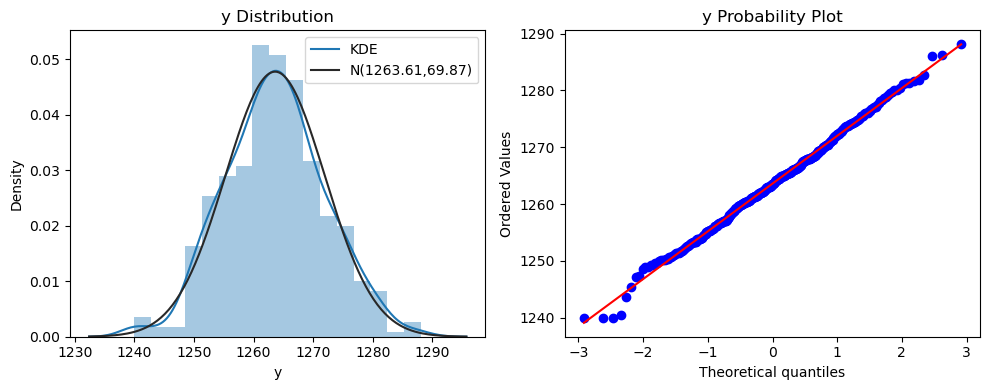

In [ ]:
QQ_plot(os_df['y'], 'y')

In [ ]:
len(os_df[os_df['y'] > 1283])

3

In [ ]:
os_df.loc[os_df['y'] < 1242, 'y_cate'] = 'A'
os_df.loc[(os_df['y'] >= 1242)&(os_df['y'] <= 1283), 'y_cate'] = 'B'
os_df.loc[os_df['y'] > 1283, 'y_cate'] = 'C'

In [ ]:
os_df, os_target = RandomOverSampler(random_state=1).fit_resample(os_df.drop('y_cate',axis=1), os_df['y_cate'])

In [ ]:
# os_df.drop('y',axis=1,inplace=True)

In [ ]:
x_train_ = os_df[os_df.columns[:x_train_.shape[1]]]
y_train_ = os_df[os_df.columns[-1]]

print(x_train.shape,y_train.shape)
print(x_train_.shape,y_train_.shape)
print(x_valid.shape,y_valid.shape)
print(x_test.shape, y_test.shape)

(488, 392) (488,)
(1149, 392) (1149,)
(98, 392) (98,)
(123, 392) (123,)
